**Reference:**
- https://zhuanlan.zhihu.com/p/546008084

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import plyfile
import tqdm
from typing import Any, Dict, List, Tuple
import xml.etree.ElementTree as etree
import mitsuba as mi
import pymeshlab
mi.set_variant('cuda_ad_rgb')

In [2]:
import yaml
import argparse

def load_hparams(path):
    with open(path, 'r', encoding='utf-8') as f:
        result = yaml.load(f.read(), Loader=yaml.FullLoader)
    hparams = argparse.Namespace(**result)
    return hparams

In [77]:
# Modified from https://github.com/OuyangJunyuan/PointCloudRenderer
class PointcloudVisualizer(object):
    def __init__(self, hparams: argparse.Namespace) -> None:
        super(PointcloudVisualizer, self).__init__()
        self.hparams = hparams
        # load point cloud
        assert os.path.exists(hparams.pcd_file), f'input path {hparams.pcd_file} does not exist.'
        self.pts = self.load_from_ply(hparams.pcd_file, hparams.sample_number, hparams.sample_method)
        # process pts
        self.pts = self.pts[:, [2, 0, 1]]
        self.pts[:, 0] *= -1
        self.pts[:, 1] *= -1
        self.pts[:, 2] += 0.0125 # 抬升一点距离
        self.floor_height = self.pts[:, 2].min() - 0.0125
        # create dict for mitsuba scene description.
        self.scene_dict = self.create_environment(hparams.sample_count, hparams.width, hparams.height, hparams.camera_file)
        self.scene_dict.update(self.create_objects(hparams.pts_size, hparams.pts_color))

    def farthest_point_sampling(self, pts: np.array, sample_number: int) -> np.ndarray:
        """
        Modified from: https://zhuanlan.zhihu.com/p/400427336
        Input:
            pts: pointcloud data, [N, 3]
            sample_number: number of samples
        Return:
            centroids: sampled pointcloud index, [sample_number,]
        """
        # 获取形状
        N, C = pts.shape
        # 采样点矩阵(npoint,)
        centroids = np.zeros(sample_number, dtype=np.uint32)
        # 采样点到所有点距离(N,)
        distance = np.ones(N) * 1e10
        #计算重心坐标 及 距离重心最远的点, 将距离重心最远的点作为第一个点
        barycenter = np.mean(pts, 0)
        dist = np.sum((pts - barycenter) ** 2, -1)
        farthest = np.argmax(dist)
        # 遍历
        for i in tqdm.trange(sample_number):
            # 更新第i个最远点
            centroids[i] = farthest
            # 取出这个最远点的xyz坐标
            centroid = pts[farthest, :]
            # 计算点集中的所有点到这个最远点的欧式距离
            dist = np.sum((pts - centroid) ** 2, -1)
            mask = dist < distance
            # 更新distance，记录样本中每个点距离所有已出现的采样点的最小距离
            distance[mask] = dist[mask]
            # 返回最远点索引
            farthest = np.argmax(distance)
        return centroids

    def load_from_ply(self, file_path: str, sample_number: int=0, sample_method: str='fps') -> np.ndarray:
        """
        Load points from a ply file
        :param filepath: The path of the file to read from
        :return: An ndarray (Nx3) containing all read points
        """
        plydata = plyfile.PlyData.read(file_path)
        pts = plydata['vertex'].data
        pts_np = []
        for p in pts:
            pts_np.append([p[0], p[1], p[2]])
        pts_np = np.array(pts_np)
        print(f'loaded pointclod shape: {pts_np.shape}.')
        if sample_number > 0 and sample_number < pts_np.shape[0]:
            if sample_method == 'fps':
                print(f'using farthest point sampling to sample {sample_number} points.')
                pt_indices = self.farthest_point_sampling(pts_np, sample_number)
            elif sample_method == "random":
                print(f'using random sampling to sample {sample_number} points.')
                pt_indices = np.random.choice(pts.shape[0], sample_number, replace=False)
            else:
                raise NotImplementedError(f'sample method {sample_method} is not implemented.')
            pts_np = pts_np[pt_indices, :]
            print(f'pointclod shape after sampling: {pts_np.shape}.')
        elif sample_number > pts_np.shape[0]:
            print(f'sample number {sample_number} > total number {pts_np.shape[0]}, no sampling is performed, use all points.')
        else:
            print(f'No sampling is performed, use all points.')
        return pts_np

    def convert_camera_meshlab2mitsuba(self, file_path: str, film: Dict[str, Any], sampler: Dict[str, Any]) -> List[Dict[str, Any]]:
        """
        Reads meshlab camera properties from an xml file. To obtain those, simply press ctrl/cmd+c in meshlab, and paste into a text editor.
        If you paste multiple cameras into one file, make sure to have a valid document structure with one root node, e.g.
        <!DOCTYPE ViewState>
        <project>
        <VCGCamera ... />
        <ViewSettings ... />
        </project>

        :param file_path: Path to the xml file to read
        :return: A list of Mitsuba transforms
        """
        assert file_path.endswith('.xml'), 'Invalid camera file.'
        root_node = etree.parse(file_path).getroot()
        meshlab_cameras = [elem.attrib for elem in root_node if elem.tag == 'VCGCamera']
        mitsuba_cameras = []
        for c in meshlab_cameras:
            # Meshlab camera matrix is transposed
            matrix = np.array([
                float(elem) for elem in c['RotationMatrix'].split(' ')[:16]
            ]).reshape(4, 4).transpose()
            translation = [-float(elem) for elem in c['TranslationVector'].split(' ')]
            for i in range(3):
                matrix[i, 3] = translation[i]
            transform = mi.Transform4f(matrix)
            transform = transform @ transform.scale(mi.Vector3f(-1, 1, -1))
            transform = transform.matrix.numpy()[0]
            position = transform[:3, 3]
            look = transform[:3, :3].dot(np.array([0, 0, 1]))
            up = transform[:3, :3].dot(np.array([0, 1, 0]))
            # transform
            position = position[[2, 0, 1]]
            position[0] *= -1
            position[1] *= -1
            position[2] += 0.0125 # see init()
            look = look[[2, 0, 1]]
            look[0] *= -1
            look[1] *= -1
            look[2] += 0.0125 # see init()
            up = up[[2, 0, 1]]
            up[0] *= -1
            up[1] *= -1
            up[2] += 0.0125 # see init()
            mitsuba_cameras.append({
                "type": "perspective",
                "near_clip": 0.1,  # Distance to the near clip planes
                "far_clip": 100.0,  # Distance to the far clip planes
                "to_world": mi.ScalarTransform4f.look_at(
                    origin=position*self.hparams.camera_scale, # scale to make object small
                    target=position+look,
                    up=up
                    ),
                "film": film,
                "sampler": sampler
            })
        return mitsuba_cameras

    def create_environment(self, sample_count: int=256, width: int=1920, height: int=1080, camera_file: str=None) -> Dict[str, Any]:
        """
        Create the environment for the scene
        :param sample_count: Specify the sample times, the higher the better, which result have less noise.
        :return: A dict containing the environment description
        """
        # https://mitsuba2.readthedocs.io/en/latest/generated/plugins.html#integrators
        integer = {
            "type": "path",
            "max_depth": -1,  # Specifies the longest path depth in the generated output image, -1 means infinit.
            # "samples_per_pass": 4,
        }
        # https://mitsuba2.readthedocs.io/en/latest/generated/plugins.html#emitters
        # note that area light should be attached to a geometry object, as mentioned in the above link.
        area_emitter = {"type": "constant"}
        # https://mitsuba2.readthedocs.io/en/latest/generated/plugins.html#films
        film = {
            "type": "hdrfilm",  # high dynamic render
            "width": width,  # width of the camera snesor in pixel
            "height": height,  # height of the camera snesor in pixel
            "rfilter": {"type": "gaussian"}  # reconstruction filter
        }
        # https://mitsuba2.readthedocs.io/en/latest/generated/plugins.html#samplers
        sampler = {
            "type": "independent",  # independent sampling with a uniform distribution.
            "sample_count": sample_count  # the higher the better, which result have less noise.
        }
        # https://mitsuba2.readthedocs.io/en/latest/generated/plugins.html#sensors
        if camera_file is not None:
            mitsuba_cameras = self.convert_camera_meshlab2mitsuba(camera_file, film, sampler)
            assert len(mitsuba_cameras)>0, f'No camera found in {camera_file}.'
            camera = mitsuba_cameras[0]
        else:
            camera = {
                "type": "perspective",
                "near_clip": 0.1,  # Distance to the near clip planes
                "far_clip": 100.0,  # Distance to the far clip planes
                "to_world": mi.ScalarTransform4f.look_at(
                    origin=[0, 2, 0],
                    target=[0, 0, 0],
                    up=[0, 0, 1]
                    ),
                "film": film,
                "sampler": sampler
            }
        # scene dict
        scene = {
            "type": "scene",
            "integer": integer,
            "sensor": camera,
            "emitter": area_emitter
        }
        return scene

    def normalize_uint8_color(self, uint8_color_list: List) -> np.ndarray:
        """
        Normalize the colors to be in the range [0, 1]
        :param colors: The colors to normalize
        :return: The normalized colors
        """
        return [i / 255. for i in uint8_color_list]

    def get_predefined_spectrum_color(self, name: str) -> List:
        """
        Get a predefined spectrum from a name string.
        Currently supports: light_blue, cornflower_blue, orange
        :param name: The spectrum name
        :return: A Mitsuba Spectrum Color
        """
        if name == 'light_blue': # 浅蓝
            return self.normalize_uint8_color([160, 180, 200])
        elif name == 'cornflower_blue': # 矢车菊蓝
            return self.normalize_uint8_color([100, 149, 237])
        elif name == 'orange': # 橘黄
            return self.normalize_uint8_color([200, 160, 0])
        elif name == 'pink': # 粉红
            return self.normalize_uint8_color([255, 192, 203])
        elif name == 'medium_orchid': # 中兰紫
            return self.normalize_uint8_color([186, 85, 211])
        elif name == 'mint_green': # 薄荷绿
            return self.normalize_uint8_color([22, 152, 43])
        elif name == 'light_slate_gray': # 亮岩灰
            return self.normalize_uint8_color([119, 136, 153])
        else:
            raise ValueError

    def create_spheres(self, pts: np.ndarray, sphere_color: str = 'orange', sphere_radius: float = 1.) -> List:
        """
        Create little spheres at the pointcloud's points' locations.
        :param pointcloud: 3D pointcloud, as Nx3 ndarray
        :param spectrum: The color spectrum to use with the spheres' diffuse bsdf
        :param sphere_radius: The radius to use for each sphere
        :return: A list of mitsuba shapes, to be added to a Scene
        """
        spheres = []
        for row in pts:
            sphere = mi.load_dict({
                'type': 'sphere',
                'center': [float(row[0]), float(row[1]), float(row[2])],
                'radius': sphere_radius,
                'bsdf': {
                    'type': 'diffuse',
                    'reflectance': {
                        'type': 'srgb',
                        'color': self.get_predefined_spectrum_color(sphere_color)
                    }
                },
            })
            spheres.append(sphere)
        return spheres

    def create_objects(self, pts_size: float = 0.01, pts_color: str='orange') -> Dict[str, Any]:
        ground = {  # to make shadow
            "type": "rectangle",
            "bsdf": {
                'type': 'diffuse',
                'reflectance': {
                    'type': 'srgb',
                    'color': [1., 1., 1.]
                }
            },
            # "to_world": mi.ScalarTransform4f.translate([0, 0, -0.5]) @ mi.ScalarTransform4f.scale([10, 10, 1]),
            "to_world": mi.ScalarTransform4f.translate([0, 0, self.floor_height]) @ mi.ScalarTransform4f.scale([10, 10, 1]),
        }
        # ground plane that shadow projected to.
        objs = {"ground_plane": ground, }
        # objs = {}
        spheres = self.create_spheres(self.pts, pts_color, pts_size)
        # add rest to scene dict
        for i, obj in enumerate(spheres):
            objs[f"shape_{i+1}"] = obj
        return objs

    def render(self) -> None:
        # load scene from dict
        scene = mi.load_dict(self.scene_dict)
        sensor = scene.sensors()[0]  # select the first camera to have a view.
        scene.integrator().render(scene, sensor)
        # save the render result.
        film = sensor.film()
        self.image = film.bitmap(raw=True).convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.UInt8, srgb_gamma=True)
        self.show()

    def show(self) -> None:
        if hasattr(self, 'image'):
            plt.imshow(self.image)
            plt.show()
        else:
            print('Please run render() to generate rendered image data.')

    def save(self, save_file: str) -> None:
        if hasattr(self, 'image'):
            self.image.write(save_file)
        else:
            print('Please run render() to generate rendered image data.')

Namespace(camera_file='./dataset/camera.xml', camera_scale=1.7, height=1920, pcd_file='./dataset/scene0031_00_6.ply', pts_color='light_slate_gray', pts_size=0.01, sample_count=256, sample_method='fps', sample_number=3000, width=1920)
loaded pointclod shape: (8309, 3).
using farthest point sampling to sample 3000 points.


100%|██████████| 3000/3000 [00:00<00:00, 5327.71it/s]


pointclod shape after sampling: (3000, 3).


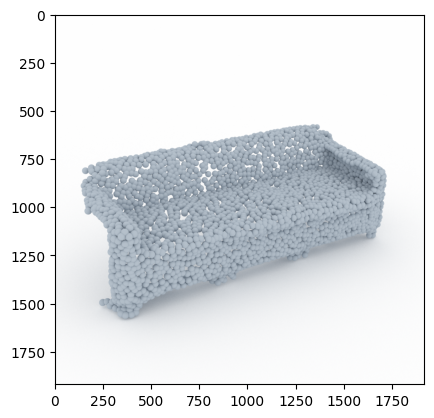

In [86]:
hparams = load_hparams('./test_data/pcd_conf.yaml')
hparams.width = 1920
hparams.height = 1920
hparams.pcd_file = './dataset/scene0031_00_6.ply'
hparams.camera_file = './dataset/camera.xml'
# hparams.camera_file = None
#! 如下三种颜色用于数据集展示
# hparams.pts_color = 'cornflower_blue' # for real domain
# hparams.pts_color = 'medium_orchid'
# hparams.pts_color = 'orange' # for synthetic domain
# hparams.pts_color = 'mint_green'
hparams.pts_color = 'light_slate_gray'
hparams.sample_number = 3000
hparams.pts_size = 0.01
hparams.camera_scale = 1.7
print(hparams)
a = PointcloudVisualizer(hparams)
a.render()
if hparams.pcd_file.endswith('.ply'):
    save_file = os.path.join('./results', os.path.basename(hparams.pcd_file).replace('.ply', '.png'))
elif hparams.pcd_file.endswith('.obj'):
    save_file = os.path.join('./results', os.path.basename(hparams.pcd_file).replace('.obj', '.png'))
else:
    raise NotImplementedError(f"Unsupported mesh file: {hparams.pcd_file}.")
a.save(save_file)

In [74]:
# Modified from https://github.com/OuyangJunyuan/PointCloudRenderer
class MeshVisualizer(object):
    def __init__(self, hparams: argparse.Namespace) -> None:
        super(MeshVisualizer, self).__init__()
        self.hparams = hparams
        # load mesh
        assert os.path.exists(hparams.mesh_file), f'input path {hparams.mesh_file} does not exist.'
        self.mesh_file = self.convert_mesh(hparams.mesh_file)
        # create dict for mitsuba scene description.
        self.scene_dict = self.create_environment(hparams.sample_count, hparams.width, hparams.height, hparams.camera_file)
        self.scene_dict.update(self.create_objects(self.mesh_file, hparams.mesh_color))

    def convert_mesh(self, mesh_file: str) -> str:
        if mesh_file.endswith('.obj'):
            mesh_file_ply = mesh_file.replace('.obj', '.ply')
            if os.path.exists(mesh_file_ply):
                print(f'{mesh_file_ply} exists, no converting.')
            else:
                ms = pymeshlab.MeshSet()
                ms.load_new_mesh(mesh_file)
                ms.save_current_mesh(mesh_file.replace('.obj', '.ply'), save_vertex_color=False, save_face_color=False, save_wedge_color=False, save_wedge_texcoord=False, save_wedge_normal=False)
                print(f'{mesh_file} is converted to {mesh_file_ply}.')
        else:
            mesh_file_ply = mesh_file
            print('ply file, no converting.')
        save_file = mesh_file_ply.replace('.ply', '_mitsuba.ply')
        if os.path.exists(save_file):
            print(f'{save_file} exists, no converting.')
        else:
            print(f'{save_file} does not exist, converting...')
            plydata = plyfile.PlyData.read(mesh_file_ply)
            # process pts
            pts = plydata['vertex'].data
            pts_np = np.array([[x, y, z] for x,y,z in pts])
            pts_np = pts_np[:, [2, 0, 1]]
            pts_np[:, 0] *= -1
            pts_np[:, 1] *= -1
            pts_np[:, 2] += 0.0125 # 抬升一点距离
            points = [(pts_np[i,0], pts_np[i,1], pts_np[i,2]) for i in range(pts_np.shape[0])]
            vertex = np.array(points, dtype=[('x', 'f4'), ('y', 'f4'),('z', 'f4')])
            vertex = plyfile.PlyElement.describe(vertex, 'vertex', comments=['vertices'])
            face = plydata['face']
            plyfile.PlyData([vertex, face]).write(mesh_file_ply.replace('.ply', '_mitsuba.ply'))
            print(f'{save_file} saved.')
        plydata = plyfile.PlyData.read(save_file)
        pts = plydata['vertex'].data
        pts_np = []
        for p in pts:
            pts_np.append([p[0], p[1], p[2]])
        pts_np = np.array(pts_np)
        self.floor_height = pts_np[:, 2].min() - 0.0125
        return save_file

    def convert_camera_meshlab2mitsuba(self, file_path: str, film: Dict[str, Any], sampler: Dict[str, Any]) -> List[Dict[str, Any]]:
        """
        Reads meshlab camera properties from an xml file. To obtain those, simply press ctrl/cmd+c in meshlab, and paste into a text editor.
        If you paste multiple cameras into one file, make sure to have a valid document structure with one root node, e.g.
        <!DOCTYPE ViewState>
        <project>
        <VCGCamera ... />
        <ViewSettings ... />
        </project>

        :param file_path: Path to the xml file to read
        :return: A list of Mitsuba transforms
        """
        assert file_path.endswith('.xml'), 'Invalid camera file.'
        root_node = etree.parse(file_path).getroot()
        meshlab_cameras = [elem.attrib for elem in root_node if elem.tag == 'VCGCamera']
        mitsuba_cameras = []
        for c in meshlab_cameras:
            # Meshlab camera matrix is transposed
            matrix = np.array([
                float(elem) for elem in c['RotationMatrix'].split(' ')[:16]
            ]).reshape(4, 4).transpose()
            translation = [-float(elem) for elem in c['TranslationVector'].split(' ')]
            for i in range(3):
                matrix[i, 3] = translation[i]
            transform = mi.Transform4f(matrix)
            transform = transform @ transform.scale(mi.Vector3f(-1, 1, -1))
            transform = transform.matrix.numpy()[0]
            position = transform[:3, 3]
            look = transform[:3, :3].dot(np.array([0, 0, 1]))
            up = transform[:3, :3].dot(np.array([0, 1, 0]))
            # transform
            position = position[[2, 0, 1]]
            position[0] *= -1
            position[1] *= -1
            position[2] += 0.0125 # see init()
            look = look[[2, 0, 1]]
            look[0] *= -1
            look[1] *= -1
            look[2] += 0.0125 # see init()
            up = up[[2, 0, 1]]
            up[0] *= -1
            up[1] *= -1
            up[2] += 0.0125 # see init()
            mitsuba_cameras.append({
                "type": "perspective",
                "near_clip": 0.1,  # Distance to the near clip planes
                "far_clip": 100.0,  # Distance to the far clip planes
                "to_world": mi.ScalarTransform4f.look_at(
                    origin=position*self.hparams.camera_scale, # scale to make object small
                    target=position+look,
                    up=up
                    ),
                "film": film,
                "sampler": sampler
            })
        return mitsuba_cameras

    def create_environment(self, sample_count: int=256, width: int=1920, height: int=1080, camera_file: str=None) -> Dict[str, Any]:
        """
        Create the environment for the scene
        :param sample_count: Specify the sample times, the higher the better, which result have less noise.
        :return: A dict containing the environment description
        """
        # https://mitsuba2.readthedocs.io/en/latest/generated/plugins.html#integrators
        integer = {
            "type": "path",
            "max_depth": -1,  # Specifies the longest path depth in the generated output image, -1 means infinit.
            # "samples_per_pass": 4,
        }
        # https://mitsuba2.readthedocs.io/en/latest/generated/plugins.html#emitters
        # note that area light should be attached to a geometry object, as mentioned in the above link.
        area_emitter = {"type": "constant"}
        # https://mitsuba2.readthedocs.io/en/latest/generated/plugins.html#films
        film = {
            "type": "hdrfilm",  # high dynamic render
            "width": width,  # width of the camera snesor in pixel
            "height": height,  # height of the camera snesor in pixel
            "rfilter": {"type": "gaussian"}  # reconstruction filter
        }
        # https://mitsuba2.readthedocs.io/en/latest/generated/plugins.html#samplers
        sampler = {
            "type": "independent",  # independent sampling with a uniform distribution.
            "sample_count": sample_count  # the higher the better, which result have less noise.
        }
        # https://mitsuba2.readthedocs.io/en/latest/generated/plugins.html#sensors
        if camera_file is not None:
            mitsuba_cameras = self.convert_camera_meshlab2mitsuba(camera_file, film, sampler)
            assert len(mitsuba_cameras)>0, f'No camera found in {camera_file}.'
            camera = mitsuba_cameras[0]
        else:
            camera = {
                "type": "perspective",
                "near_clip": 0.1,  # Distance to the near clip planes
                "far_clip": 100.0,  # Distance to the far clip planes
                "to_world": mi.ScalarTransform4f.look_at(
                    origin=[0, 2, 0],
                    target=[0, 0, 0],
                    up=[0, 0, 1]
                    ),
                "film": film,
                "sampler": sampler
            }
        # scene dict
        scene = {
            "type": "scene",
            "integer": integer,
            "sensor": camera,
            "emitter": area_emitter
        }
        return scene

    def normalize_uint8_color(self, uint8_color_list: List) -> np.ndarray:
        """
        Normalize the colors to be in the range [0, 1]
        :param colors: The colors to normalize
        :return: The normalized colors
        """
        return [i / 255. for i in uint8_color_list]

    def get_predefined_spectrum_color(self, name: str) -> List:
        """
        Get a predefined spectrum from a name string.
        Currently supports: light_blue, cornflower_blue, orange
        :param name: The spectrum name
        :return: A Mitsuba Spectrum Color
        """
        if name == 'light_blue': # 浅蓝
            return self.normalize_uint8_color([160, 180, 200])
        elif name == 'cornflower_blue': # 矢车菊蓝
            return self.normalize_uint8_color([100, 149, 237])
        elif name == 'orange': # 橘黄
            return self.normalize_uint8_color([200, 160, 0])
        elif name == 'pink': # 粉红
            return self.normalize_uint8_color([255, 192, 203])
        elif name == 'medium_orchid': # 中兰紫
            return self.normalize_uint8_color([186, 85, 211])
        elif name == 'mint_green': # 薄荷绿
            return self.normalize_uint8_color([22, 152, 43])
        elif name == 'light_slate_gray': # 亮岩灰
            return self.normalize_uint8_color([119, 136, 153])
        else:
            raise ValueError

    def create_objects(self, mesh_file: str, mesh_color: str = 'orange') -> Dict[str, Any]:
        ground = {  # to make shadow
            "type": "rectangle",
            "bsdf": {
                'type': 'diffuse',
                'reflectance': {
                    'type': 'srgb',
                    'color': [1., 1., 1.]
                }
            },
            # "to_world": mi.ScalarTransform4f.translate([0, 0, -0.5]) @ mi.ScalarTransform4f.scale([10, 10, 1]),
            "to_world": mi.ScalarTransform4f.translate([0, 0, self.floor_height]) @ mi.ScalarTransform4f.scale([10, 10, 1]),
        }
        # objs
        objs = {
            "ground_plane": ground, # ground plane that shadow projected to.
            "instance": { # mesh
                'type': 'ply',
                'filename': mesh_file,
                'face_normals': True,
                'bsdf': {
                    'type': 'twosided',
                    'material': {
                        # 'type': 'diffuse',
                        # 'reflectance': {
                        #     'type': 'srgb',
                        #     'color': self.get_predefined_spectrum_color(mesh_color)
                        #     }
                        'type': 'roughplastic',
                        "distribution": "ggx",
                        "alpha": 0.05,
                        "int_ior": 1.46,
                        "nonlinear": True,
                        'diffuse_reflectance': {
                            'type': 'srgb',
                            'color': self.get_predefined_spectrum_color(mesh_color)
                            }
                        }
                    }
                }
            }
        return objs

    def render(self) -> None:
        # load scene from dict
        scene = mi.load_dict(self.scene_dict)
        sensor = scene.sensors()[0]  # select the first camera to have a view.
        scene.integrator().render(scene, sensor)
        # save the render result.
        film = sensor.film()
        self.image = film.bitmap(raw=True).convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.UInt8, srgb_gamma=True)
        self.show()

    def show(self) -> None:
        if hasattr(self, 'image'):
            plt.imshow(self.image)
            plt.show()
        else:
            print('Please run render() to generate rendered image data.')

    def save(self, save_file: str) -> None:
        if hasattr(self, 'image'):
            self.image.write(save_file)
        else:
            print('Please run render() to generate rendered image data.')

Namespace(camera_file='./dataset/camera.xml', camera_scale=1.7, height=1920, mesh_color='light_slate_gray', mesh_file='./dataset/scene0031_00_6_m.obj', sample_count=256, width=1920)
./dataset/scene0031_00_6_m.ply exists, no converting.
./dataset/scene0031_00_6_m_mitsuba.ply exists, no converting.


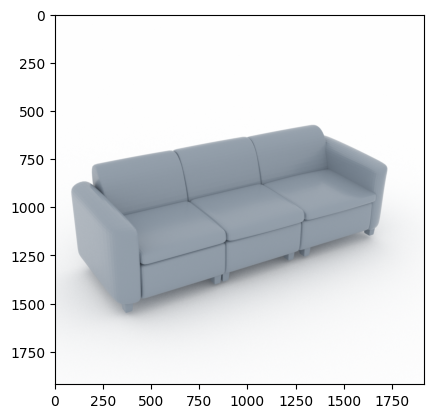

In [87]:
hparams = load_hparams('./test_data/mesh_conf.yaml')
hparams.width = 1920
hparams.height = 1920
hparams.mesh_file = './dataset/scene0031_00_6_m.obj'
hparams.camera_file = './dataset/camera.xml'
# hparams.camera_file = None
#! 如下五种颜色用于数据集展示
# hparams.mesh_color = 'cornflower_blue' # for real domain
# hparams.mesh_color = 'medium_orchid'
# hparams.mesh_color = 'orange' # for synthetic domain
# hparams.mesh_color = 'mint_green'
hparams.mesh_color = 'light_slate_gray'
hparams.camera_scale = 1.7
print(hparams)
b = MeshVisualizer(hparams)
b.render()
if hparams.mesh_file.endswith('.ply'):
    save_file = os.path.join('./results', os.path.basename(hparams.mesh_file).replace('.ply', '.png'))
elif hparams.mesh_file.endswith('.obj'):
    save_file = os.path.join('./results', os.path.basename(hparams.mesh_file).replace('.obj', '.png'))
else:
    raise NotImplementedError(f"Unsupported mesh file: {hparams.mesh_file}.")
b.save(save_file)

In [61]:
# Modified from https://github.com/OuyangJunyuan/PointCloudRenderer
class MultiObjectVisualizer(object):
    def __init__(self, hparams: argparse.Namespace) -> None:
        super(MultiObjectVisualizer, self).__init__()
        self.hparams = hparams
        self.floor_height = None
        # load point cloud
        self.pcds = self.load_pcds(hparams.pcd_files, hparams.sample_number, hparams.sample_method)
        # load mesh
        self.mesh_files = self.load_meshes(hparams.mesh_files)
        # create dict for mitsuba scene description.
        self.scene_dict = self.create_environment(hparams.sample_count, hparams.width, hparams.height, hparams.camera_file)
        self.scene_dict.update(self.create_objects(self.pcds, hparams.pts_color, hparams.pts_size, self.mesh_files, hparams.mesh_color))

    def load_pcds(self, pcd_files: List[str], sample_number: int, sample_method: str) -> List[np.ndarray]:
        loaded_pcds = []
        for pcd_file in pcd_files:
            assert os.path.exists(pcd_file), f'input path {pcd_file} does not exist.'
            loaded_pcd = self.load_from_ply(pcd_file, sample_number, sample_method)
            loaded_pcds.append(loaded_pcd)
        return loaded_pcds

    def farthest_point_sampling(self, pts: np.array, sample_number: int) -> np.ndarray:
        """
        Modified from: https://zhuanlan.zhihu.com/p/400427336
        Input:
            pts: pointcloud data, [N, 3]
            sample_number: number of samples
        Return:
            centroids: sampled pointcloud index, [sample_number,]
        """
        # 获取形状
        N, C = pts.shape
        # 采样点矩阵(npoint,)
        centroids = np.zeros(sample_number, dtype=np.uint32)
        # 采样点到所有点距离(N,)
        distance = np.ones(N) * 1e10
        #计算重心坐标 及 距离重心最远的点, 将距离重心最远的点作为第一个点
        barycenter = np.mean(pts, 0)
        dist = np.sum((pts - barycenter) ** 2, -1)
        farthest = np.argmax(dist)
        # 遍历
        for i in tqdm.trange(sample_number):
            # 更新第i个最远点
            centroids[i] = farthest
            # 取出这个最远点的xyz坐标
            centroid = pts[farthest, :]
            # 计算点集中的所有点到这个最远点的欧式距离
            dist = np.sum((pts - centroid) ** 2, -1)
            mask = dist < distance
            # 更新distance，记录样本中每个点距离所有已出现的采样点的最小距离
            distance[mask] = dist[mask]
            # 返回最远点索引
            farthest = np.argmax(distance)
        return centroids

    def load_from_ply(self, file_path: str, sample_number: int=0, sample_method: str='fps') -> np.ndarray:
        """
        Load points from a ply file
        :param filepath: The path of the file to read from
        :return: An ndarray (Nx3) containing all read points
        """
        plydata = plyfile.PlyData.read(file_path)
        pts = plydata['vertex'].data
        pts_np = []
        for p in pts:
            pts_np.append([p[0], p[1], p[2]])
        pts_np = np.array(pts_np)
        print(f'loaded pointclod shape: {pts_np.shape}.')
        if sample_number > 0 and sample_number < pts_np.shape[0]:
            if sample_method == 'fps':
                print(f'using farthest point sampling to sample {sample_number} points.')
                pt_indices = self.farthest_point_sampling(pts_np, sample_number)
            elif sample_method == "random":
                print(f'using random sampling to sample {sample_number} points.')
                pt_indices = np.random.choice(pts.shape[0], sample_number, replace=False)
            else:
                raise NotImplementedError(f'sample method {sample_method} is not implemented.')
            pts_np = pts_np[pt_indices, :]
            print(f'pointclod shape after sampling: {pts_np.shape}.')
        elif sample_number > pts_np.shape[0]:
            print(f'sample number {sample_number} > total number {pts_np.shape[0]}, no sampling is performed, use all points.')
        else:
            print(f'No sampling is performed, use all points.')
        pts_np = pts_np[:, [2, 0, 1]]
        pts_np[:, 0] *= -1
        pts_np[:, 1] *= -1
        pts_np[:, 2] += 0.0125 # 抬升一点距离
        cur_floor_height = pts_np[:, 2].min() - 0.0125
        if self.floor_height is None:
            self.floor_height = cur_floor_height
        elif self.floor_height > cur_floor_height:
            self.floor_height = cur_floor_height
        return pts_np

    def load_meshes(self, mesh_files: List[str]) -> List[str]:
        loaded_files = []
        for mesh_file in mesh_files:
            assert os.path.exists(mesh_file), f'input path {mesh_file} does not exist.'
            loaded_file = self.convert_mesh(mesh_file)
            loaded_files.append(loaded_file)
        return loaded_files

    def convert_mesh(self, mesh_file: str) -> str:
        if mesh_file.endswith('.obj'):
            mesh_file_ply = mesh_file.replace('.obj', '.ply')
            if os.path.exists(mesh_file_ply):
                print(f'{mesh_file_ply} exists, no converting.')
            else:
                ms = pymeshlab.MeshSet()
                ms.load_new_mesh(mesh_file)
                ms.save_current_mesh(mesh_file.replace('.obj', '.ply'), save_vertex_color=False, save_face_color=False, save_wedge_color=False, save_wedge_texcoord=False, save_wedge_normal=False)
                print(f'{mesh_file} is converted to {mesh_file_ply}.')
        else:
            mesh_file_ply = mesh_file
            print('ply file, no converting.')
        save_file = mesh_file_ply.replace('.ply', '_mitsuba.ply')
        if os.path.exists(save_file):
            print(f'{save_file} exists, no converting.')
        else:
            print(f'{save_file} does not exist, converting...')
            plydata = plyfile.PlyData.read(mesh_file_ply)
            # process pts
            pts = plydata['vertex'].data
            pts_np = np.array([[x, y, z] for x,y,z in pts])
            pts_np = pts_np[:, [2, 0, 1]]
            pts_np[:, 0] *= -1
            pts_np[:, 1] *= -1
            pts_np[:, 2] += 0.0125 # 抬升一点距离
            points = [(pts_np[i,0], pts_np[i,1], pts_np[i,2]) for i in range(pts_np.shape[0])]
            vertex = np.array(points, dtype=[('x', 'f4'), ('y', 'f4'),('z', 'f4')])
            vertex = plyfile.PlyElement.describe(vertex, 'vertex', comments=['vertices'])
            face = plydata['face']
            plyfile.PlyData([vertex, face]).write(mesh_file_ply.replace('.ply', '_mitsuba.ply'))
            print(f'{save_file} saved.')
        plydata = plyfile.PlyData.read(save_file)
        pts = plydata['vertex'].data
        pts_np = []
        for p in pts:
            pts_np.append([p[0], p[1], p[2]])
        pts_np = np.array(pts_np)
        cur_floor_height = pts_np[:, 2].min() - 0.0125
        if self.floor_height is None:
            self.floor_height = cur_floor_height
        elif self.floor_height > cur_floor_height:
            self.floor_height = cur_floor_height
        return save_file

    def convert_camera_meshlab2mitsuba(self, file_path: str, film: Dict[str, Any], sampler: Dict[str, Any]) -> List[Dict[str, Any]]:
        """
        Reads meshlab camera properties from an xml file. To obtain those, simply press ctrl/cmd+c in meshlab, and paste into a text editor.
        If you paste multiple cameras into one file, make sure to have a valid document structure with one root node, e.g.
        <!DOCTYPE ViewState>
        <project>
        <VCGCamera ... />
        <ViewSettings ... />
        </project>

        :param file_path: Path to the xml file to read
        :return: A list of Mitsuba transforms
        """
        assert file_path.endswith('.xml'), 'Invalid camera file.'
        root_node = etree.parse(file_path).getroot()
        meshlab_cameras = [elem.attrib for elem in root_node if elem.tag == 'VCGCamera']
        mitsuba_cameras = []
        for c in meshlab_cameras:
            # Meshlab camera matrix is transposed
            matrix = np.array([
                float(elem) for elem in c['RotationMatrix'].split(' ')[:16]
            ]).reshape(4, 4).transpose()
            translation = [-float(elem) for elem in c['TranslationVector'].split(' ')]
            for i in range(3):
                matrix[i, 3] = translation[i]
            transform = mi.Transform4f(matrix)
            transform = transform @ transform.scale(mi.Vector3f(-1, 1, -1))
            transform = transform.matrix.numpy()[0]
            position = transform[:3, 3]
            look = transform[:3, :3].dot(np.array([0, 0, 1]))
            up = transform[:3, :3].dot(np.array([0, 1, 0]))
            # transform
            position = position[[2, 0, 1]]
            position[0] *= -1
            position[1] *= -1
            position[2] += 0.0125 # see init()
            look = look[[2, 0, 1]]
            look[0] *= -1
            look[1] *= -1
            look[2] += 0.0125 # see init()
            up = up[[2, 0, 1]]
            up[0] *= -1
            up[1] *= -1
            up[2] += 0.0125 # see init()
            mitsuba_cameras.append({
                "type": "perspective",
                "near_clip": 0.1,  # Distance to the near clip planes
                "far_clip": 100.0,  # Distance to the far clip planes
                "to_world": mi.ScalarTransform4f.look_at(
                    origin=position*self.hparams.camera_scale, # scale to make object small
                    target=position+look,
                    up=up
                    ),
                "film": film,
                "sampler": sampler
            })
        return mitsuba_cameras

    def create_environment(self, sample_count: int=256, width: int=1920, height: int=1080, camera_file: str=None) -> Dict[str, Any]:
        """
        Create the environment for the scene
        :param sample_count: Specify the sample times, the higher the better, which result have less noise.
        :return: A dict containing the environment description
        """
        # https://mitsuba2.readthedocs.io/en/latest/generated/plugins.html#integrators
        integer = {
            "type": "path",
            "max_depth": -1,  # Specifies the longest path depth in the generated output image, -1 means infinit.
            # "samples_per_pass": 4,
        }
        # https://mitsuba2.readthedocs.io/en/latest/generated/plugins.html#emitters
        # note that area light should be attached to a geometry object, as mentioned in the above link.
        area_emitter = {"type": "constant"}
        # https://mitsuba2.readthedocs.io/en/latest/generated/plugins.html#films
        film = {
            "type": "hdrfilm",  # high dynamic render
            "width": width,  # width of the camera snesor in pixel
            "height": height,  # height of the camera snesor in pixel
            "rfilter": {"type": "gaussian"}  # reconstruction filter
        }
        # https://mitsuba2.readthedocs.io/en/latest/generated/plugins.html#samplers
        sampler = {
            "type": "independent",  # independent sampling with a uniform distribution.
            "sample_count": sample_count  # the higher the better, which result have less noise.
        }
        # https://mitsuba2.readthedocs.io/en/latest/generated/plugins.html#sensors
        if camera_file is not None:
            mitsuba_cameras = self.convert_camera_meshlab2mitsuba(camera_file, film, sampler)
            assert len(mitsuba_cameras)>0, f'No camera found in {camera_file}.'
            camera = mitsuba_cameras[0]
        else:
            camera = {
                "type": "perspective",
                "near_clip": 0.1,  # Distance to the near clip planes
                "far_clip": 100.0,  # Distance to the far clip planes
                "to_world": mi.ScalarTransform4f.look_at(
                    origin=[0, 2, 0],
                    target=[0, 0, 0],
                    up=[0, 0, 1]
                    ),
                "film": film,
                "sampler": sampler
            }
        # scene dict
        scene = {
            "type": "scene",
            "integer": integer,
            "sensor": camera,
            "emitter": area_emitter
        }
        return scene

    def normalize_uint8_color(self, uint8_color_list: List) -> np.ndarray:
        """
        Normalize the colors to be in the range [0, 1]
        :param colors: The colors to normalize
        :return: The normalized colors
        """
        return [i / 255. for i in uint8_color_list]

    def get_predefined_spectrum_color(self, name: str) -> List:
        """
        Get a predefined spectrum from a name string.
        Currently supports: light_blue, cornflower_blue, orange
        :param name: The spectrum name
        :return: A Mitsuba Spectrum Color
        """
        if name == 'light_blue': # 浅蓝
            return self.normalize_uint8_color([160, 180, 200])
        elif name == 'cornflower_blue': # 矢车菊蓝
            return self.normalize_uint8_color([100, 149, 237])
        elif name == 'orange': # 橘黄
            return self.normalize_uint8_color([200, 160, 0])
        elif name == 'pink': # 粉红
            return self.normalize_uint8_color([255, 192, 203])
        elif name == 'medium_orchid': # 中兰紫
            return self.normalize_uint8_color([186, 85, 211])
        elif name == 'mint_green': # 薄荷绿
            return self.normalize_uint8_color([22, 152, 43])
        elif name == 'light_slate_gray': # 亮岩灰
            return self.normalize_uint8_color([119, 136, 153])
        else:
            raise ValueError

    def create_spheres(self, pts: np.ndarray, sphere_color: str = 'orange', sphere_radius: float = 1.) -> List:
        """
        Create little spheres at the pointcloud's points' locations.
        :param pointcloud: 3D pointcloud, as Nx3 ndarray
        :param spectrum: The color spectrum to use with the spheres' diffuse bsdf
        :param sphere_radius: The radius to use for each sphere
        :return: A list of mitsuba shapes, to be added to a Scene
        """
        spheres = []
        for row in pts:
            sphere = mi.load_dict({
                'type': 'sphere',
                'center': [float(row[0]), float(row[1]), float(row[2])],
                'radius': sphere_radius,
                'bsdf': {
                    'type': 'diffuse',
                    'reflectance': {
                        'type': 'srgb',
                        'color': self.get_predefined_spectrum_color(sphere_color)
                    }
                },
            })
            spheres.append(sphere)
        return spheres

    def create_objects(self, pcds: np.ndarray, pts_color: str, pts_size: float, mesh_files: str, mesh_color: str = 'orange') -> Dict[str, Any]:
        ground = {  # to make shadow
            "type": "rectangle",
            "bsdf": {
                'type': 'diffuse',
                'reflectance': {
                    'type': 'srgb',
                    'color': [1., 1., 1.]
                }
            },
            # "to_world": mi.ScalarTransform4f.translate([0, 0, -0.5]) @ mi.ScalarTransform4f.scale([10, 10, 1]),
            "to_world": mi.ScalarTransform4f.translate([0, 0, self.floor_height]) @ mi.ScalarTransform4f.scale([10, 10, 1]),
        }
        # objs
        objs = {"ground_plane": ground,} # ground plane that shadow projected to.
        for i, p in enumerate(pcds):
            spheres = self.create_spheres(p, pts_color, pts_size)
            for j, s in enumerate(spheres):
                objs[f"shape_{i}_{j}"] = s
        for i, m in enumerate(mesh_files):
            objs[f"instance_{i}"] = { # mesh
                'type': 'ply',
                'filename': m,
                'face_normals': True,
                'bsdf': {
                    'type': 'twosided',
                    'material': {
                        'type': 'roughplastic',
                        "distribution": "ggx",
                        "alpha": 0.05,
                        "int_ior": 1.46,
                        "nonlinear": True,
                        'diffuse_reflectance': {
                            'type': 'srgb',
                            'color': self.get_predefined_spectrum_color(mesh_color)
                            }
                        }
                    }
                }
        return objs

    def render(self) -> None:
        # load scene from dict
        scene = mi.load_dict(self.scene_dict)
        sensor = scene.sensors()[0]  # select the first camera to have a view.
        scene.integrator().render(scene, sensor)
        # save the render result.
        film = sensor.film()
        self.image = film.bitmap(raw=True).convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.UInt8, srgb_gamma=True)
        self.show()

    def show(self) -> None:
        if hasattr(self, 'image'):
            plt.imshow(self.image)
            plt.show()
        else:
            print('Please run render() to generate rendered image data.')

    def save(self, save_file: str) -> None:
        if hasattr(self, 'image'):
            self.image.write(save_file)
        else:
            print('Please run render() to generate rendered image data.')

In [151]:
hparams = load_hparams('./meshes/conf.yaml')
hparams.width = 1920
hparams.height = 1920
hparams.pcd_files = [
    './meshes/scene0040_00_8.ply',
]
hparams.mesh_files = [
    # './meshes/step2.obj',
    # './meshes/step3.obj',
    # './meshes/step4.obj',
    # './meshes/step5.obj',
    # './meshes/step6.obj',
    # './meshes/final.obj',
    # './meshes/scene0040_00_8.obj'
]
# hparams.camera_file = './meshes/camera.xml'
# hparams.camera_scale = 1.7
hparams.camera_file = './meshes/camera_pc.xml'
hparams.camera_scale = 1.7
# hparams.camera_file = './meshes/camera_2_3.xml'
# hparams.camera_scale = 1.8
# hparams.camera_file = None
#! 如下三种颜色用于数据集展示
# color = 'cornflower_blue' # for real domain
# color = 'medium_orchid'
# color = 'orange' # for synthetic domain
# color = 'mint_green'
# color = 'light_slate_gray'
hparams.pts_color = 'light_slate_gray'
hparams.mesh_color = 'cornflower_blue'
hparams.sample_number = 6700
hparams.sample_method = 'fps'
hparams.pts_size = 0.003
print(hparams)

Namespace(camera_file='./meshes/camera_pc.xml', camera_scale=1.7, height=1920, mesh_color='cornflower_blue', mesh_files=[], pcd_files=['./meshes/scene0040_00_8.ply'], pts_color='light_slate_gray', pts_size=0.003, sample_count=256, sample_method='fps', sample_number=6700, width=1920)


loaded pointclod shape: (6881, 3).
using farthest point sampling to sample 6700 points.


100%|██████████| 6700/6700 [00:01<00:00, 6410.66it/s]


pointclod shape after sampling: (6700, 3).


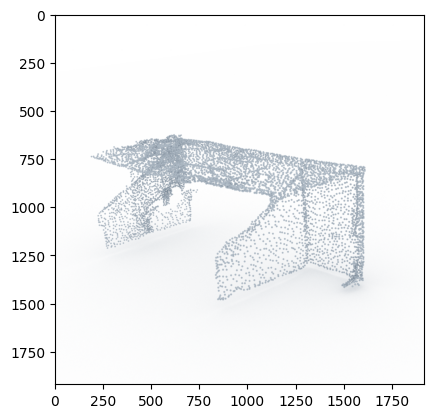

In [152]:
b = MultiObjectVisualizer(hparams)
b.render()

In [153]:
b.save('./meshes/2_1_1.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


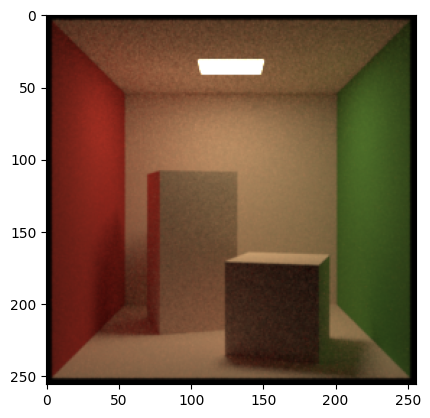

In [1]:
import mitsuba as mi
mi.set_variant('cuda_ad_rgb')
img = mi.render(mi.load_dict(mi.cornell_box()))
import matplotlib.pyplot as plt
# 简单的gamma矫正
plt.imshow(img**(1/2.4))
plt.show()